In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

from torchinfo import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(123)
if device == 'cuda':
    torch.cuda.manual_seed_all(123)

# 이미지 데이터 전처리

In [2]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        # data augmentation
        self.data_transform = {
            # 훈련 이미지 데이터에 대한 전처리
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            # 검증과 테스트 이미지 데이터에 대한 전처리
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [3]:
# 데이터셋 불러오기
train_dir='./bird/train'
val_dir="./bird/valid"
test_dir="./bird/test"

train_images_dir_list = [os.path.join(train_dir, f) for f in os.listdir(train_dir)]
train_images_filepaths = [os.path.join(d, f) for d in train_images_dir_list for f in os.listdir(d)]

val_images_dir_list = [os.path.join(val_dir, f) for f in os.listdir(val_dir)]
val_images_filepaths = [os.path.join(d, f) for d in val_images_dir_list for f in os.listdir(d)]

test_images_dir_list = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]
test_images_filepaths = [os.path.join(d, f) for d in test_images_dir_list for f in os.listdir(d)]

In [4]:
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

2382 75 75


In [5]:
# 이미지 레이블링
image_labels = {f:i for i,f in enumerate(os.listdir(train_dir))}

In [6]:
# 이미지에 대한 레이블 구분
class BirdSpeciesDataset(Dataset):
    def __init__(self, file_list, image_labels, transform=None, phase='train'):
        self.file_list = file_list
        self.image_labels = image_labels
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        specie = train_images_filepaths[idx].split('\\')[-2]
        label = self.image_labels[specie]
        return img_transformed, label

In [7]:
resize_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

resize_train = torchvision.datasets.ImageFolder(root=train_dir, transform=resize_trans)
resize_val = torchvision.datasets.ImageFolder(root=val_dir, transform=resize_trans)

In [8]:
resize_train[0][0].shape

torch.Size([3, 256, 256])

In [9]:
resize_train[0][0]

tensor([[[0.6549, 0.6667, 0.6667,  ..., 0.8980, 0.8902, 0.8824],
         [0.6431, 0.6667, 0.6824,  ..., 0.8980, 0.8941, 0.8863],
         [0.6510, 0.6627, 0.6824,  ..., 0.8941, 0.8941, 0.8902],
         ...,
         [0.8510, 0.8510, 0.8549,  ..., 0.8235, 0.8275, 0.8118],
         [0.8510, 0.8510, 0.8549,  ..., 0.8157, 0.8235, 0.8078],
         [0.8588, 0.8549, 0.8588,  ..., 0.8078, 0.8235, 0.8118]],

        [[0.6863, 0.6980, 0.6980,  ..., 0.9098, 0.9020, 0.8941],
         [0.6745, 0.6980, 0.7137,  ..., 0.9098, 0.9059, 0.8980],
         [0.6824, 0.6941, 0.7137,  ..., 0.9059, 0.9059, 0.9020],
         ...,
         [0.8706, 0.8706, 0.8745,  ..., 0.8314, 0.8353, 0.8196],
         [0.8706, 0.8706, 0.8745,  ..., 0.8235, 0.8314, 0.8196],
         [0.8745, 0.8706, 0.8745,  ..., 0.8235, 0.8392, 0.8275]],

        [[0.3922, 0.4039, 0.4039,  ..., 0.5922, 0.5843, 0.5765],
         [0.3804, 0.4039, 0.4196,  ..., 0.5922, 0.5882, 0.5804],
         [0.3882, 0.4000, 0.4196,  ..., 0.5961, 0.5922, 0.

In [10]:
np.mean(resize_train[0][0].numpy(),axis=(1,2)) # numpy로 바꾸고, axis = 1,2 mean으로 RGB mean/std 뽑기

array([0.46196648, 0.48232612, 0.40833154], dtype=float32)

In [11]:
def get_mean_std(dataset):
    meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
    stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]
    
    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])

    print(meanR, meanG, meanB)
    print(stdR, stdG, stdB)

In [12]:
#get_mean_std(resize_train)

0.49696147 0.49023795 0.4595283
0.19612093 0.19693258 0.20676239


In [13]:
#get_mean_std(resize_val)

0.5137743 0.50221324 0.4701747
0.1900865 0.18764344 0.19879578


In [12]:
size = 224
resize_train_mean=[0.49696147, 0.49023795, 0.4595283]
resize_train_std=[0.19612093, 0.19693258, 0.20676239]

resize_test_mean=[0.5137743, 0.50221324, 0.4701747]
resize_test_std=[0.1900865, 0.18764344, 0.19879578]
batch_size = 32

In [13]:
# 이미지 데이터셋 정의
train_dataset = BirdSpeciesDataset(train_images_filepaths, image_labels, transform=ImageTransform(size,resize_train_mean,resize_train_std), phase='train')
val_dataset = BirdSpeciesDataset(val_images_filepaths, image_labels, transform=ImageTransform(size,resize_test_mean,resize_test_std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [14]:
train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([10,  4, 14, 13,  4, 12,  8, 12,  6,  1, 10,  0, 13,  2, 12,  1,  0, 10,
         2,  7,  9,  2,  1, 14,  2,  3, 13, 13,  4,  8,  8,  0])


In [15]:
def imshow(img, mean, std):
    npimg = img.numpy()
    img = np.transpose( npimg, (1, 2, 0) )
    img = img * std + mean # renormalize
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.show()


none_trans = torchvision.datasets.ImageFolder(root=train_dir, transform=None)

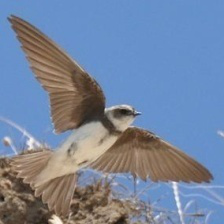

In [16]:
none_trans[2000][0]

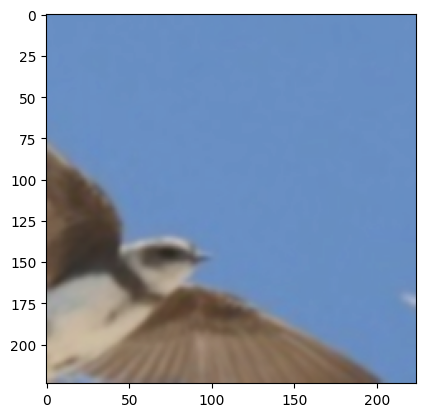

In [17]:
imshow((train_dataset.__getitem__(2000)[0]),resize_train_mean,resize_train_std)

# ResNet50

In [18]:
# 기본 블록 정의
class BasicBlock(nn.Module):    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None        
        self.downsample = downsample
        
    def forward(self, x):       
        i = x       
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [19]:
# 병목 블록 정의
class Bottleneck(nn.Module):    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None            
        self.downsample = downsample
        
    def forward(self, x):        
        i = x        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [20]:
# ResNet 모델 네트워크
class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual=False):
        super().__init__()
                
        block, n_blocks, channels = config    # ResNet을 호출할 때 념겨준 config 값들을 block, n_blocks, channels에 저장
        self.in_channels = channels[0]            
        assert len(n_blocks) == len(channels) == 4    # 블록 크기 = 채널 크기 = 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
    
    # 블록을 추가하기 위한 함수
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
        layers = []
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))    # 계층을 추가할 때 in_channels, channels, stride뿐만 아니라 
                                                                                # 다운샘플 적용 유무도 함께 전달
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels            
        return nn.Sequential(*layers)
        
    def forward(self, x):        
        x = self.conv1(x)    # 224 x 224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)    # 112 x 112
        x = self.layer1(x)    # 56 x 56
        x = self.layer2(x)    # 28 x 28
        x = self.layer3(x)    # 14 x 14
        x = self.layer4(x)    # 7 x 7
        x = self.avgpool(x)    # 1 x 1
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        return x, h

In [21]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [22]:
resnet50_config = ResNetConfig(block=Bottleneck, n_blocks=[3,4,6,3], channels=[64,128,256,512])

In [23]:
OUTPUT_DIM = 15      # 분류하고자 하는 새 종류의 수(새 종류의 수가 변경될 시 변경 필요!!!!)
resnet50 = ResNet(resnet50_config, OUTPUT_DIM)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
#summary(resnet50, (1, 3, 224, 224), depth=3)

C:\Users\User\anaconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 15]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [24]:
# 옵티마이저와 손실 함수 정의
optimizer = optim.Adam(resnet50.parameters(), lr=0.0008)
criterion = nn.CrossEntropyLoss()

resnet50 = resnet50.to(device)
criterion = criterion.to(device)

In [25]:
# 모델 학습 정확도 측정 함수
def calculate_topk_accuracy(y_pred, y, k = 15):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)    # k에서 가장 큰 값의 index
        top_pred = top_pred.t()    # 전치
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))    # tensor 비교 후 같으면 True, 다르면 False 반환
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)    # 이미지의 정확한 레이블 부여를 위해 사용
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [26]:
# 모델 학습 함수
def train(model, iterator, optimizer, criterion, device):    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()    
    for (x, y) in iterator:        
        x = x.to(device)
        y = y.to(device)
            
        optimizer.zero_grad()                
        y_pred = model(x)  
        
        loss = criterion(y_pred[0], y) 
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)        
        loss.backward()        
        optimizer.step()        
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()    # 모델이 첫 번째로 예측한 레이블
        epoch_acc_5 += acc_5.item()    # 이미지에 정확한 레이블
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [27]:
# 모델 평가 함수
def evaluate(model, iterator, criterion, device):    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()    
    with torch.no_grad():        
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)            
            loss = criterion(y_pred[0], y)
            acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [28]:
# 모델 학습 시간 측정 함수
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [29]:
# 모델 학습
best_valid_loss = float('inf')
EPOCHS = 30

for epoch in range(EPOCHS):    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(resnet50, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(resnet50, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(resnet50.state_dict(), './data/ResNet-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

C:\Users\User\anaconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 01 | Epoch Time: 0m 59s
	Train Loss: 2.564 | Train Acc @1:  19.04% | Train Acc @5: 100.00%
	Valid Loss: 4.195 | Valid Acc @1:   9.28% | Valid Acc @5: 100.00%
Epoch: 02 | Epoch Time: 0m 58s
	Train Loss: 2.063 | Train Acc @1:  30.03% | Train Acc @5: 100.00%
	Valid Loss: 5.713 | Valid Acc @1:   4.17% | Valid Acc @5: 100.00%
Epoch: 03 | Epoch Time: 0m 58s
	Train Loss: 1.939 | Train Acc @1:  33.60% | Train Acc @5: 100.00%
	Valid Loss: 4.651 | Valid Acc @1:   6.25% | Valid Acc @5: 100.00%
Epoch: 04 | Epoch Time: 0m 58s
	Train Loss: 1.829 | Train Acc @1:  37.76% | Train Acc @5: 100.00%
	Valid Loss: 5.992 | Valid Acc @1:   4.17% | Valid Acc @5: 100.00%
Epoch: 05 | Epoch Time: 0m 58s
	Train Loss: 1.681 | Train Acc @1:  43.10% | Train Acc @5: 100.00%
	Valid Loss: 6.668 | Valid Acc @1:   6.25% | Valid Acc @5: 100.00%
Epoch: 06 | Epoch Time: 0m 58s
	Train Loss: 1.654 | Train Acc @1:  42.90% | Train Acc @5: 100.00%
	Valid Loss: 7.797 | Valid Acc @1:   6.25% | Valid Acc @5: 100.00%
Epoch: 07 